## Importing libaries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import nltk
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot,Tokenizer
from keras.models import Sequential
from keras.layers import LSTM,Dense,Embedding

## Loading dataset

In [2]:
df = pd.read_csv('reviews.csv')
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


## EDA and Data Preprocessing

In [3]:
# overall information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [4]:
# dropping irrelevant columns
df.drop(['Time_submitted','Total_thumbsup','Reply'],inplace=True,axis=1)

In [5]:
# lowercaing the column names
df.columns = df.columns.str.lower()

In [6]:
df.head()

,review,rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


In [7]:
df.duplicated().sum()

201

In [8]:
# removing rows with similar values
df.drop_duplicates(inplace=True)

In [9]:
df['rating'].unique()

array([5, 4, 1, 3, 2], dtype=int64)

In [10]:
df.iloc[40,0]

"What's the deal here? Compared to the desktop version, this is inferior to it! Why is the ability to play any songs so bare or if not, barely free? Is there more that need to be said about this? I think I made my point clear enough!"

<Axes: xlabel='rating', ylabel='count'>

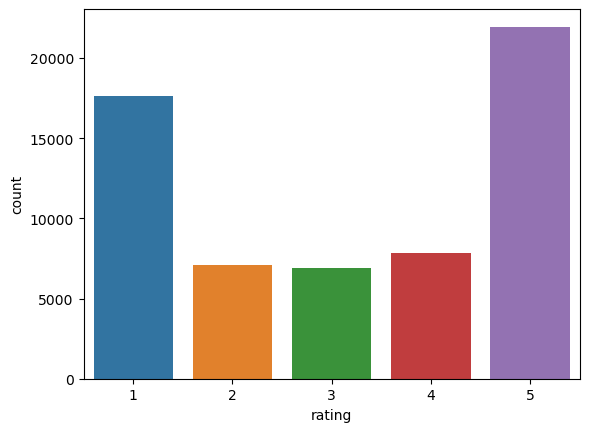

In [11]:
# visualizing the distribution of rating columns
sns.countplot(x=df['rating'])

In [12]:
df[df['rating'] == 3].shape

(6881, 2)

In [13]:
df.iloc[17,0]

"I can't listen to my DOWNLOADED playlist while I'm offline. So what's the point of this feature? Disappointed.."

In [14]:
df[df['rating'] == 4].head()

,review,rating
2,"This pop-up ""Get the best Spotify experience o...",4
21,His voice is so sweet and hearable,4
24,An amazing music experience,4
29,Everything is perfect... Just Add Light Theme,4
36,Sometimes I try and listen to a Playlist and i...,4


In [15]:
df.iloc[24,0]
df.iloc[36,0]

'Sometimes I try and listen to a Playlist and it will play the same first song and I try to go to a different one and it goes back to the same first one... little weird.'

In [16]:
# this function is for new column called 'target', we consider rating 5 & 4 as 'positive' and 1,2,3 as 'negative'
def new_col(x):
    if x == 5 or x == 4:
        return 'Positive'
    else:
        return 'Negative'

In [17]:
df['target'] = df['rating'].apply(new_col)

In [18]:
df.head()

,review,rating,target
0,"Great music service, the audio is high quality...",5,Positive
1,Please ignore previous negative rating. This a...,5,Positive
2,"This pop-up ""Get the best Spotify experience o...",4,Positive
3,Really buggy and terrible to use as of recently,1,Negative
4,Dear Spotify why do I get songs that I didn't ...,1,Negative


In [19]:
df[df['rating'] == 3].head(2)

,review,rating,target
5,The player controls sometimes disappear for no...,3,Negative
7,Still extremely slow when changing storage to ...,3,Negative


<Axes: xlabel='target', ylabel='count'>

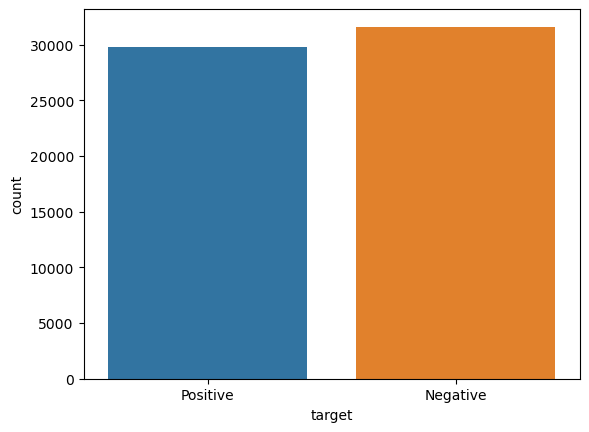

In [20]:
# now visualizing the target column,the distribution is now balanced
sns.countplot(x = df['target'])

In [21]:
def preprocess_text(sentence):
    tag_pattern = re.compile(r'<.*?>')
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    # Lowercasing
    sent = sentence.lower()
    # Removal of HTML Tags
    sent = re.sub(tag_pattern, '', sent)
    # Removing Punctuation & Special Characters
    sent = re.sub('[^a-zA-Z]',' ',sent)
    # removing single character
    sent = re.sub(r"\s+[a-zA-Z]\s+",' ',sent)
    # removing multiple spaces
    sent = re.sub(r'\s+',' ',sent)
    # Removal of URLs
    sent = re.sub(url_pattern,'',sent)
    return sent

In [22]:
X = []
corpus = list(df['review'])
for line in corpus:
    X.append(preprocess_text(line))

In [23]:
X[36]

'sometimes try and listen to playlist and it will play the same first song and try to go to different one and it goes back to the same first one little weird '

In [24]:
y = df['target'].map({'Positive':1,'Negative':0})

## Splitting into train and test the tokenizing

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,random_state=42)

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # splitting sentence into tokens
X_train = tokenizer.texts_to_sequences(X_train)# assigning tokens numerical values
X_test = tokenizer.texts_to_sequences(X_test) # assigning tokens numerical values

input_dim = len(tokenizer.word_index) + 1

## Padding to ensure all sentences are of same length

In [27]:
maxlen = 100
X_train = pad_sequences(X_train,padding='pre',maxlen = maxlen)
X_test = pad_sequences(X_test,padding='pre',maxlen = maxlen)

In [28]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


## Downloading word2Vec and creating embedding matrix of 100 dim

In [30]:
w2v = api.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [31]:
embedding_matrix = np.zeros((input_dim,100))
for word,index in tokenizer.word_index.items():
    if word in w2v:
        embedding_matrix[index] = w2v[word]

## Building the model


In [32]:
from keras.layers import Dropout
model = Sequential([
    Embedding(input_dim = input_dim,output_dim = 100,weights = [embedding_matrix],input_length = maxlen,trainable = False),
    Dropout(0.2), # this prevent overfitting
    LSTM(128),
    Dropout(0.2), # this prevent overfitting
    Dense(1,activation = 'sigmoid')
])

## Compiling the model

In [33]:
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics = ['accuracy'])

## Fitting the model

In [34]:
history = model.fit(X_train,y_train,batch_size = 128,epochs = 10, verbose = 1,validation_split = 0.2)

Epoch 1/10


307/307 [==============================] - 78s 217ms/step - loss: 0.4116 - accuracy: 0.8173 - val_loss: 0.3533 - val_accuracy: 0.8513
Epoch 2/10
307/307 [==============================] - 64s 210ms/step - loss: 0.3648 - accuracy: 0.8442 - val_loss: 0.3368 - val_accuracy: 0.8592
Epoch 3/10
307/307 [==============================] - 64s 207ms/step - loss: 0.3434 - accuracy: 0.8563 - val_loss: 0.3367 - val_accuracy: 0.8575
Epoch 4/10
307/307 [==============================] - 65s 210ms/step - loss: 0.3261 - accuracy: 0.8634 - val_loss: 0.3148 - val_accuracy: 0.8704
Epoch 5/10
307/307 [==============================] - 65s 211ms/step - loss: 0.3158 - accuracy: 0.8695 - val_loss: 0.3105 - val_accuracy: 0.8745
Epoch 6/10
307/307 [==============================] - 66s 215ms/step - loss: 0.3060 - accuracy: 0.8754 - val_loss: 0.3121 - val_accuracy: 0.8736
Epoch 7/10
307/307 [==============================] - 64s 209ms/step - loss: 0.2992 - accuracy: 0.8782 - val_loss: 0.3065 - val_

In [35]:
# our model did not overfit since test accuracy and train accuracy are almost the same
model.evaluate(X_test,y_test)

384/384 [==============================] - 15s 38ms/step - loss: 0.3023 - accuracy: 0.8776


[0.3023368716239929, 0.8775959014892578]

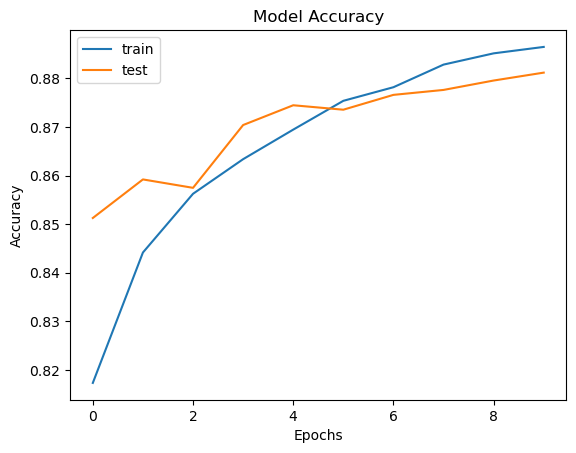

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

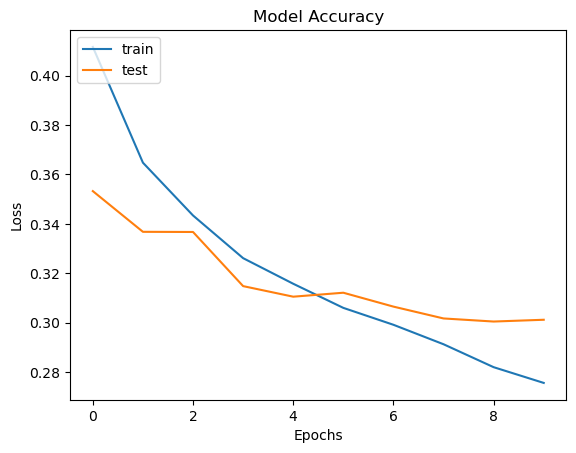

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

In [39]:
# if y_pred is larger than 0.5 it returns 1 else 0
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

384/384 [==============================] - 12s 32ms/step


In [40]:
print(y_pred)

[[False]
 [ True]
 [ True]
 ...
 [False]
 [ True]
 [False]]


## Defining a predictor

In [41]:
sent = "I love the selection and the lyrics are provided with the song you're listening to!"
x = []
x.append(preprocess_text(sent))
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,padding='pre',maxlen = 100)

In [42]:
model.predict(x)

1/1 [==============================] - 0s 88ms/step


array([[0.98965317]], dtype=float32)

In [43]:
import pickle
pickle.dump(tokenizer,open('spotifytokenizer.pkl','wb'))
model.save('spotifyReviewModel.keras')